<a href="https://colab.research.google.com/github/jeonggunlee/DeepLearningBasics/blob/master/Lab07_introduction_to_convnets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###한림대학교 소프트웨어 융합 대학

##딥러닝 기초: 오픈소스 Keras를 활용하여!!!
##MNIST 숫자 이미지 인식~

이정근 교수

jeonggun.lee@hallym.ac.kr 

2020년 8월

In [1]:
import keras
keras.__version__

Using TensorFlow backend.


'2.3.1'

## 이하 자료는 모두 다음 사이트의 내용에서 가져온 자료입다.

https://github.com/rickiepark/deep-learning-with-python-notebooks

원작자: François Chollet, https://github.com/fchollet

한글화: Haesun Park (rickiepark) https://github.com/rickiepark


---



# 5.1 - 합성곱 신경망 소개

이 노트북은 [케라스 창시자에게 배우는 딥러닝](https://tensorflow.blog/케라스-창시자에게-배우는-딥러닝/) 책의 5장 1절의 코드 예제입니다. 책에는 더 많은 내용과 그림이 있습니다. 이 노트북에는 소스 코드에 관련된 설명만 포함합니다. 이 노트북의 설명은 케라스 버전 2.2.2에 맞추어져 있습니다. 케라스 최신 버전이 릴리스되면 노트북을 다시 테스트하기 때문에 설명과 코드의 결과가 조금 다를 수 있습니다.

----

컨브넷의 정의와 컨브넷이 컴퓨터 비전 관련 작업에 잘 맞는 이유에 대해 이론적 배경을 알아보겠습니다. 하지만 먼저 간단한 컨브넷 예제를 둘러 보죠. 2장에서 완전 연결 네트워크로 풀었던(이 방식의 테스트 정확도는 97.8%였습니다) MNIST 숫자 이미지 분류에 컨브넷을 사용해 보겠습니다. 기본적인 컨브넷이더라도 2장의 완전 연결된 모델의 성능을 훨씬 앞지를 것입니다.

다음 코드는 기본적인 컨브넷의 모습입니다. `Conv2D`와 `MaxPooling2D` 층을 쌓아 올렸습니다. 잠시 후에 이들이 무엇인지 배우겠습니다.

컨브넷이 `(image_height, image_width, image_channels)` 크기의 입력 텐서를 사용한다는 점이 중요합니다(배치 차원은 포함하지 않습니다). 이 예제에서는 MNIST 이미지 포맷인 `(28, 28, 1)` 크기의 입력을 처리하도록 컨브넷을 설정해야 합니다. 이 때문에 첫 번째 층의 매개변수로 `input_shape=(28, 28, 1)`을 전달합니다.

In [2]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

지금까지 컨브넷 구조를 출력해 보죠:

In [3]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 64)          36928     
Total params: 55,744
Trainable params: 55,744
Non-trainable params: 0
_________________________________________________________________


첫번째 층인 **conv2d_1 (Conv2D)**의 파라미터 수는 왜 320일까요 ?

3by3 convolution filter의 파라미터 개수는 9개이지요. 그리고 그런 필터가 32개 있다면, 전체 파라미터의 수는 9 * 32 = 288입니다. 여기다 각 필터마다 bias의 수 32를 더하면 288 + 32 = 320개가 됩니다.

그럼 두번째 layer인 **conv2d_2**의 파라미터 수는 어떻게 18496 개가 되었을까요 ?

3x3 필터가 64개 있으므로, 32 feature map에 대해서 3x3x64, 즉 32x3x3x64 = 18432. 여기에 필터별 bias의 값 64를 더하면, 18432 + 64 = 18496 이 됩니다!




---



`Conv2D`와 `MaxPooling2D` 층의 출력은 `(height, width, channels)` 크기의 3D 텐서입니다. 높이와 넓이 차원은 네트워크가 깊어질수록 작아지는 경향이 있습니다. 채널의 수는 `Conv2D` 층에 전달된 첫 번째 매개변수에 의해 조절됩니다(32개 또는 64개).


![Convolution Filter](https://cdn-images-1.medium.com/max/1600/1*Fw-ehcNBR9byHtho-Rxbtw.gif)


다음 단계에서 마지막 층의 (`(3, 3, 64)` 크기인) 출력 텐서를 완전 연결 네트워크에 주입합니다. 이 네트워크는 이미 익숙하게 보았던 `Dense` 층을 쌓은 분류기입니다. 이 분류기는 1D 벡터를 처리하는데 이전 층의 출력이 3D 텐서입니다. 그래서 먼저 3D 출력을 1D 텐서로 펼쳐야 합니다. 그다음 몇 개의 `Dense` 층을 추가합니다:

In [4]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

10개의 클래스를 분류하기 위해 마지막 층의 출력 크기를 10으로 하고 소프트맥스 활성화 함수를 사용합니다. 이제 전체 네트워크는 다음과 같습니다:

In [5]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)               

여기에서 볼 수 있듯이 `(3, 3, 64)` 출력이 `(576,)` 크기의 벡터로 펼쳐진 후 `Dense` 층으로 주입되었습니다.

이제 MNIST 숫자 이미지에 이 컨브넷을 훈련합니다. 2장의 MNIST 예제 코드를 많이 재사용하겠습니다.

In [6]:
from keras.datasets import mnist
from keras.utils import to_categorical
import numpy as np

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images.reshape((60000, 28, 28, 1))
test_images = test_images.reshape((10000, 28, 28, 1))

11493376/11490434 [==============================] - 0s 0us/step


In [7]:
import matplotlib.pyplot as plt

first_image = train_images[1]

d = train_images[1]
d = d.reshape(28,28)
for row in range(0,28):
  for col in range(0,28):
    print("%02X " % d[row][col], end="")
  print("") 

00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 
00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 
00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 
00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 
00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 33 9F FD 9F 32 00 00 00 00 00 00 00 00 
00 00 00 00 00 00 00 00 00 00 00 00 00 00 30 EE FC FC FC ED 00 00 00 00 00 00 00 00 
00 00 00 00 00 00 00 00 00 00 00 00 00 36 E3 FD FC EF E9 FC 39 06 00 00 00 00 00 00 
00 00 00 00 00 00 00 00 00 00 00 0A 3C E0 FC FD FC CA 54 FC FD 7A 00 00 00 00 00 00 
00 00 00 00 00 00 00 00 00 00 00 A3 FC FC FC FD FC FC 60 BD FD A7 00 00 00 00 00 00 
00 00 00 00 00 00 00 00 00 00 33 EE FD FD BE 72 FD E4 2F 4F FF A8 00 00 00 00 00 00 
00 00 00 00 00 00 00 00 00 30 EE FC FC B3 0C 4B 79 15 00 00 FD F3 32 00 00 00 00 00 
00 00 00 00 00 00 00 00 26 A5 FD E9 D0 54 00 00 00 00 00 00 FD FC

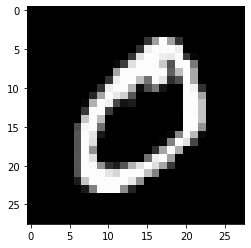

5


In [8]:
first_image = np.array(first_image, dtype='float')
pixels = first_image.reshape((28, 28))
plt.imshow(pixels, cmap='gray')
plt.show()

print(train_labels[0])

In [9]:
train_images = train_images.astype('float32') / 255
test_images = test_images.astype('float32') / 255

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

In [10]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(train_images, train_labels, epochs=5, batch_size=64)

Epoch 1/5
60000/60000 [==============================] - 10s 165us/step - loss: 0.1738 - accuracy: 0.9454
Epoch 2/5
60000/60000 [==============================] - 4s 61us/step - loss: 0.0458 - accuracy: 0.9856
Epoch 3/5
60000/60000 [==============================] - 4s 61us/step - loss: 0.0311 - accuracy: 0.9901
Epoch 4/5
60000/60000 [==============================] - 4s 62us/step - loss: 0.0237 - accuracy: 0.9925
Epoch 5/5
60000/60000 [==============================] - 4s 60us/step - loss: 0.0191 - accuracy: 0.9944


테스트 데이터에서 모델을 평가해 보죠:

In [11]:
test_loss, test_acc = model.evaluate(test_images, test_labels)

10000/10000 [==============================] - 1s 63us/step


In [12]:
test_acc

0.991599977016449

2장의 완전 연결 네트워크는 97.8%의 테스트 정확도를 얻은 반면, 기본적인 컨브넷은 99.2%의 테스트 정확도를 얻었습니다. 에러율이 (상대적으로) 64%나 줄었습니다. 나쁘지 않군요!